# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [40]:
% matplotlib inline
% pprint off

### import the libraries you think its necessary for your task
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from skimage import img_as_ubyte
from skimage import io
from skimage import exposure as exp
from skimage import color as clr

Pretty printing has been turned OFF


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [2]:
def cont_str(image):
    '''Linear contrast streching function, streches contrast of input image in output range [0, 255]'''
    min_out = 0
    max_out = 255
    min_in = image.min()
    max_in = image.max()

    k = (max_out - min_out)/(max_in - min_in)
    m = (min_out*(max_in - min_in) - min_in*(max_out - min_out))/(max_in - min_in)
    
    #function for streching our array, it will be applied for every element
    y = np.vectorize(lambda x: k*x+m, otypes=['uint8'])
    
    return y(image)

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

/home/okozyn/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


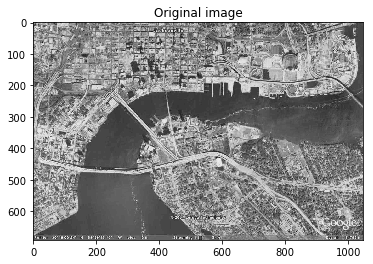

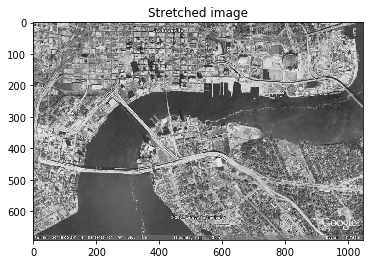

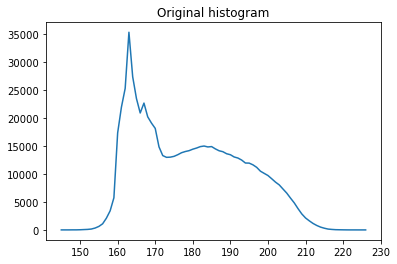

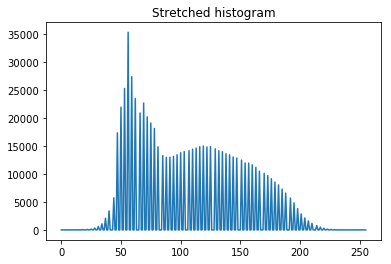

In [43]:
img_path = "./images/"
img_names = ["lena-grey.bmp", "satellite.jpg", "vibot-color.jpg", "angle_0.bmp", "bin_image.png"]
img_satellite = img_as_ubyte(io.imread(img_path + img_names[1], as_grey = True))
hst_satellite = exp.histogram(img_satellite)

img_str = cont_str(img_satellite)
hst_str = exp.histogram(img_str)

plt.imshow(img_satellite, cmap = cm.Greys_r)
plt.title("Original image")
plt.show()
plt.imshow(img_str, cmap = cm.Greys_r)
plt.title("Stretched image")
plt.show()

plt.plot(hst_satellite[1], hst_satellite[0])
plt.title("Original histogram")
plt.show()
plt.plot(hst_str[1], hst_str[0])
plt.title("Stretched histogram")
plt.show()

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [44]:
def hist_eq(image, min_intens = 0, max_intens = 255):
    #histogram calculation
    hist, bins = exp.histogram(image)
    
    #histogram normalization
    norm_hist = hist/hist.sum()
    
    #cumulative distribution calc
    cml_distr = np.zeros(len(norm_hist))
    
    for index, value in enumerate(norm_hist):
        if (index != 0):
            cml_distr[index] = cml_distr[index-1] + value
        else:
            cml_distr[0] = value  
            
    cml_min = cml_distr.min()
    norm = cml_distr.size - 1
    eq_hist = map(lambda x: round(min_intens + (x - cml_min) * (max_intens - min_intens), 0), cml_distr)
    
    #map for old-new values of intesities
    hist_dict = dict(zip(bins, eq_hist))
    
    equalize = np.vectorize(lambda x: hist_dict[x], otypes=['uint8'])
    
    return (equalize(image), cml_distr*hist.sum())    

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [45]:
img_hist_eq, cml_sat = hist_eq(img_satellite, 50, 200)
hist_eq_sat = exp.histogram(img_hist_eq)

**Show the transformed image and its histogram**

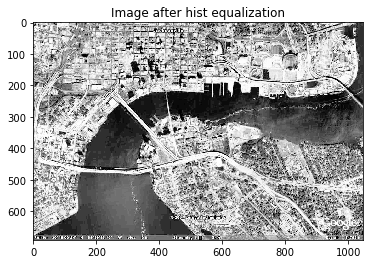

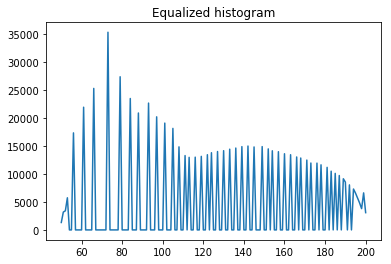

In [47]:
plt.imshow(img_hist_eq, cmap = cm.Greys_r)
plt.title("Image after hist equalization")
plt.show()
plt.plot(hist_eq_sat[1], hist_eq_sat[0])
plt.title("Equalized histogram")
plt.show()

### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

Image histogram matching transforms input (reference) image  histogram in the way that it would be similar to the predefined histogram (target). Histogram equalization is particular case of histogram matching. Following, we calculate the cumulative distribution functions of the two histograms – $F_1()$, for the reference image and $F_2()$, for the target image. Then for each gray level $G_{1}\in [0,255]$ of reference image, we find the gray level $G_{2}$, for which $F_{1}(G_{1})=F_{2}(G_{2})$, and this is the result of histogram matching function: $M(G_{1})=G_{2}$. Finally, we apply the function $M()$ on each pixel of the reference image.

In [61]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [62]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

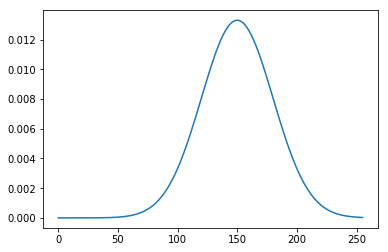

In [63]:
from scipy.stats import norm

#I have added the line below, I suppose it should its value
max_img = 255

x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)

plt.plot(x, pdf_to_fit)

**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

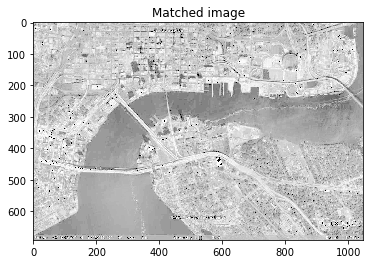

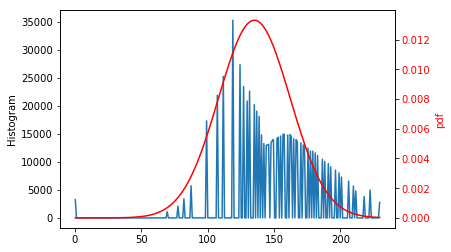

In [69]:
img_match = hist_match(img_satellite, pdf_to_fit, 0, 255)

hist_m, bins = exp.histogram(img_match)

plt.imshow(img_match, cmap = cm.Greys_r)
plt.title("Matched image")
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(bins, hist_m)
ax1.set_ylabel("Histogram")

ax2 = ax1.twinx()
ax2.plot(bins, pdf_to_fit, 'r-')
ax2.set_ylabel('pdf', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


The general formula for log transformation is $s = c\log(1+r)$, where $c$ is a constant and $r\geq0$. This transformation maps a norrow range of low gray-level values in the input image into a wide range of output levels. The opposite is true for higher values of input levels. 


For gamma transformation we have $s = cr^\gamma$, where $c$ and $\gamma$ are positive constants. As in the case of the log transformation gamma transform with $0 < \gamma < 1$ maps a narrow range of dark input values into a wider range of output values, the opposite being true for higher values of input levels. In contrary to the log transform, the gamma transformation will have exactly the opposite properties if $\gamma > 1$. Moreover, this transformation reduces to the identity transfomation when $c = \gamma =1$.

** Explain how sigmoid function enhances the image **

The general formula for sigmoid transformation is $s = \frac{1}{1 + \exp{\left(c(t - r)\right)}}$. This transformation improves the contrast of the image by streching image grer-level range nonlinearly.